In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

In [3]:
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dictionary = {w: i for i, w in enumerate(word_list)}
number_dictionary = {i: w for i, w in enumerate(word_list)}
dictionary_size = len(word_dictionary)  # vocab list
dictionary_size

11

In [4]:
one_hot = np.eye(dictionary_size)
one_hot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [5]:
def sentence_to_batch(sentences):
    input_ = [word_dictionary[word] for word in sentences[0].split()]
    output_ = [word_dictionary[word] for word in sentences[1].split()]
    target_ = [word_dictionary[word] for word in sentences[2].split()]
    
    onehot_input = [one_hot[i] for i in input_]
    onehot_output = [one_hot[i] for i in output_]

    input_tensor = torch.FloatTensor([onehot_input])
    output_tensor = torch.FloatTensor([onehot_output])
    target_tensor = torch.LongTensor([target_])
    
    return input_tensor, output_tensor, target_tensor


sentence_to_batch(sentences)

(tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]]),
 tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]]),
 tensor([[ 7,  5,  0,  4, 10]]))

In [6]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.encoder_cell = nn.RNN(input_size=dictionary_size, hidden_size=hidden_size, dropout=0.2)
        self.decoder_cell = nn.RNN(input_size=dictionary_size, hidden_size=hidden_size, dropout=0.2)
        
        self.out = nn.Linear(hidden_size * 2, dictionary_size)


    def forward(self, encoder_inputs, hidden, decoder_inputs):
        encoder_inputs = encoder_inputs.transpose(0, 1) 
        decoder_inputs = decoder_inputs.transpose(0, 1)

        encoder_outputs, encoder_hidden = self.encoder_cell(encoder_inputs, hidden)

        trained_attention = []
        hidden = encoder_hidden
        number_of_cells = len(decoder_inputs)
        model = torch.empty([number_of_cells, 1, dictionary_size])

        for i in range(number_of_cells):  
            
            decoder_output, hidden = self.decoder_cell(decoder_inputs[i].unsqueeze(0), hidden)
            attention_weights = self.attention_weight(decoder_output, encoder_outputs) 
            trained_attention.append(attention_weights.squeeze().data.numpy())
        
            context = attention_weights.bmm(encoder_outputs.transpose(0, 1))
            decoder_output = decoder_output.squeeze(0) 
            context = context.squeeze(1) 
     
            model[i] = self.out(torch.cat((decoder_output, context), dim=1))

        model = model.transpose(0, 1).squeeze(0)
        
        return model, trained_attention

    def attention_weight(self, decoder_output, encoder_outputs): 
        number_of_cells = len(encoder_outputs)
        attn_scores = torch.zeros(number_of_cells)

        for i in range(number_of_cells):
            attn_scores[i] = self.attention_score(decoder_output, encoder_outputs[i])
        
        attention_value = F.softmax(attn_scores).view(1, 1, -1)
        return attention_value

    def attention_score(self, decoder_output, encoder_output):
        decoder_hidden_state = decoder_output
        encoder_hidden_state = encoder_output
        score = torch.dot(decoder_hidden_state.view(-1), encoder_hidden_state.view(-1))
        return score

In [7]:
hidden_size = 128 # number of hidden units in one cell

hidden = torch.zeros(1, 1, hidden_size)

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = sentence_to_batch(sentences)

Attention()

/home/moonstar/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Attention(
  (encoder_cell): RNN(11, 128, dropout=0.2)
  (decoder_cell): RNN(11, 128, dropout=0.2)
  (out): Linear(in_features=256, out_features=11, bias=True)
)

In [8]:
# Train
for epoch in range(2000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

/home/moonstar/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000489
Epoch: 0800 cost = 0.000159
Epoch: 1200 cost = 0.000079
Epoch: 1600 cost = 0.000047
Epoch: 2000 cost = 0.000031


In [9]:
# Test
test_batch = [np.eye(dictionary_size)[[word_dictionary[n] for n in 'SPPPP']]]
test_batch = torch.FloatTensor(test_batch)
predict, trained_attention = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dictionary[n.item()] for n in predict.squeeze()])

ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


/home/moonstar/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/home/moonstar/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/home/moonstar/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


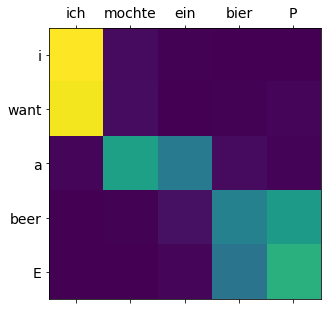

In [10]:
# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attention, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()